# Import packages 

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder


# Load the data

In [16]:
df=pd.read_csv('new_df.csv').drop(columns='Unnamed: 0')

In [17]:
df.head()

,Country_Region,Date,month,day,Population,Weight,Target,TargetValue
0,Afghanistan,2020-01-23,1,23,27657145,0.058359,ConfirmedCases,0.0
1,Afghanistan,2020-01-23,1,23,27657145,0.583587,Fatalities,0.0
2,Afghanistan,2020-01-24,1,24,27657145,0.058359,ConfirmedCases,0.0
3,Afghanistan,2020-01-24,1,24,27657145,0.583587,Fatalities,0.0
4,Afghanistan,2020-01-25,1,25,27657145,0.058359,ConfirmedCases,0.0


In [159]:
# obtian fatality cases data 
fatality=df[df.Target=='Fatalities'].drop(columns='Target')
fatality[fatality.Date=='2020-02-04'].head(-50)

,Country_Region,Date,month,day,Population,Weight,TargetValue
25,Afghanistan,2020-02-04,2,4,27657145,0.583587,0.0
273,Albania,2020-02-04,2,4,2886026,0.672251,0.0
521,Algeria,2020-02-04,2,4,40400000,0.570961,0.0
769,Andorra,2020-02-04,2,4,78014,0.887732,0.0
1017,Angola,2020-02-04,2,4,25868000,0.585874,0.0
...,...,...,...,...,...,...,...
845209,US,2020-02-04,2,4,136034,0.845976,0.0
845457,US,2020-02-04,2,4,404198,0.774614,0.0
845705,US,2020-02-04,2,4,50990,0.922560,0.0
845953,US,2020-02-04,2,4,24443,0.989693,0.0


# Data Standardization

In [19]:
# normalized the data 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(fatality.drop(columns=['TargetValue','Country_Region','Date']))

In [46]:
# create datefrane fir scaled data
scaled_df=pd.DataFrame(data=scaled,columns=fatality.drop(columns=['TargetValue','Country_Region','Date']).columns)

In [21]:
fa=fatality.copy()
fa[scaled_df.columns]=np.array(scaled_df)
fa['country']=list(fa.Country_Region)


,Country_Region,Date,month,day,Population,Weight,TargetValue,country
1,Afghanistan,2020-01-23,0.0,0.733333,0.019815,0.0616,0.0,Afghanistan
3,Afghanistan,2020-01-24,0.0,0.766667,0.019815,0.0616,0.0,Afghanistan
5,Afghanistan,2020-01-25,0.0,0.800000,0.019815,0.0616,0.0,Afghanistan
7,Afghanistan,2020-01-26,0.0,0.833333,0.019815,0.0616,0.0,Afghanistan
9,Afghanistan,2020-01-27,0.0,0.866667,0.019815,0.0616,0.0,Afghanistan


In [22]:
fa=fa.set_index(['Country_Region','Date'])
fa.head()

month       day  Population  Weight  TargetValue  \
Country_Region Date                                                           
Afghanistan    2020-01-23    0.0  0.733333    0.019815  0.0616          0.0   
               2020-01-24    0.0  0.766667    0.019815  0.0616          0.0   
               2020-01-25    0.0  0.800000    0.019815  0.0616          0.0   
               2020-01-26    0.0  0.833333    0.019815  0.0616          0.0   
               2020-01-27    0.0  0.866667    0.019815  0.0616          0.0   

                               country  
Country_Region Date                     
Afghanistan    2020-01-23  Afghanistan  
               2020-01-24  Afghanistan  
               2020-01-25  Afghanistan  
               2020-01-26  Afghanistan  
               2020-01-27  Afghanistan

# Train Test Split

In [23]:
def train_test_split(data):
    size=int(len(data)*0.8)
    # for train data will be collected from each country's data which index is from 0-size (80%)
    x_train =data.drop(columns=['TargetValue']).iloc[0:size] 
    # for test data will be collected from each country's  data which index is from size to the end (20%)
    x_test = data.drop(columns=['TargetValue']).iloc[size:]
    y_train=data['TargetValue'].iloc[0:size] 
    y_test=data['TargetValue'].iloc[size:] 
    return x_train, x_test,y_train,y_test

In [24]:
country=list(set(fa.country))
# loop each station and collect train and test data 
X_train=[]
X_test=[]
Y_train=[]
Y_test=[]
for i in range(0,len(country)):
    data=fa[fa['country']==country[i]]
    x_train, x_test,y_train,y_test=train_test_split(data)
    X_train.append(x_train)
    X_test.append(x_test)
    Y_train.append(y_train)
    Y_test.append(y_test)

In [25]:
# concat each train data from each station 
X_train=pd.concat(X_train)
Y_train=pd.DataFrame(pd.concat(Y_train))
# concat each test data from each station 
X_test=pd.concat(X_test)
Y_test=pd.DataFrame(pd.concat(Y_test))

In [26]:
# double check the train data and test data and our target 
X_train.head(2)

month       day  Population    Weight  country
Country_Region Date                                                      
Vietnam        2020-01-23    0.0  0.733333    0.066415  0.039792  Vietnam
               2020-01-24    0.0  0.766667    0.066415  0.039792  Vietnam

# Data pre-processing

In [27]:
# Code Source: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [28]:
# create the reshape function
def reshape_data(train,test):
    #Frame as supervised learning and drop all time t columns except PM2.5
    reframed_train = series_to_supervised(train, 1, 1)
    reframed_test = series_to_supervised(test, 1, 1)
    # split into train and test sets
    train= reframed_train.values
    test=reframed_test.values
    # split into input and outputs
    train_X, y_train = train[:, :-1], train[:, -1]
    test_X, y_test = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    x_train = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    x_test = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return x_train,x_test,y_train,y_test


In [112]:
encoder = LabelEncoder()
#combine x train and y train as train data 
train_data=pd.DataFrame()
train_data[X_train.columns]=X_train
train_data[Y_train.columns]=Y_train
train_data['country']= encoder.fit_transform(train_data['country'])
#combine x test and y test as test data 
test_data=pd.DataFrame()
test_data[X_test.columns]=X_test
test_data[Y_test.columns]=Y_test
test_data['country']= encoder.fit_transform(test_data['country'])
test_data.shape

(85922, 6)

In [38]:
# using the function to obtian reshaped x_train,x_test,y_train,y_test
x_train,x_test,y_train,y_test=reshape_data(train_data,test_data)

# Model 


In [188]:
# design network for confirmed cases data 
model = Sequential()
model.add(LSTM(60, activation='relu',input_shape=(x_train.shape[1], x_train.shape[2])))

model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(x_train, y_train, epochs=30, batch_size=50, verbose=1, shuffle=False)


Epoch 1/30
343489/343489 [==============================] - 24s 70us/step - loss: 0.6791
Epoch 2/30
343489/343489 [==============================] - 21s 61us/step - loss: 0.5681
Epoch 3/30
343489/343489 [==============================] - 15s 45us/step - loss: 0.5546
Epoch 4/30
343489/343489 [==============================] - 16s 48us/step - loss: 0.5419
Epoch 5/30
343489/343489 [==============================] - 15s 44us/step - loss: 0.5308
Epoch 6/30
343489/343489 [==============================] - 15s 44us/step - loss: 0.5295
Epoch 7/30
343489/343489 [==============================] - 16s 46us/step - loss: 0.5176
Epoch 8/30
343489/343489 [==============================] - 15s 44us/step - loss: 0.5148
Epoch 9/30
343489/343489 [==============================] - 15s 44us/step - loss: 0.4975
Epoch 10/30
343489/343489 [==============================] - 15s 44us/step - loss: 0.4922
Epoch 11/30
343489/343489 [==============================] - 16s 45us/step - loss: 0.5098
Epoch 12/30
343489/

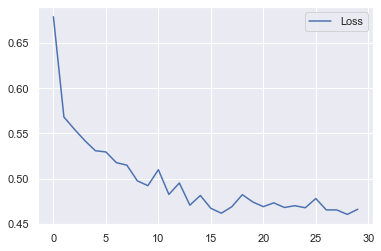

In [190]:
# plot history
plt.plot(history.history['loss'], label='Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Make prediction

In [191]:
# make a prediction
y_test_pre=model.predict(x_test)

In [192]:
y_test_pre.shape,y_test.shape

((85921, 1), (85921,))

In [193]:
# combine scaled data with predicted target
df_inverse1=X_test[scaled_df.columns]
# inverse test data
test_inv_pre=pd.DataFrame(scaler.inverse_transform(df_inverse1))
# get the month and day columns
month_day=test_inv_pre[[0,1]]
# obtian the date
import datetime
date=[]
for i in range(len(month_day)):
    d = datetime.datetime(2020, int(month_day[0][i]),int(month_day[1][i])).date()
    date.append(d)

# Data Evaluation

In [194]:
# a little tricky thing is y_test prediction has one day lag so we need re-match the date 
len([i[0] for i in y_test_pre][1:]),len(y_test[:-1])  

(85920, 85920)

In [195]:
pa=pd.DataFrame()
pa['Date']=date[1:-1]
pa['Prediction']=[i[0] for i in y_test_pre][1:] 
pa['Actual Values']=y_test[:-1]
pa.head()

,Date,Prediction,Actual Values
0,2020-05-02,0.000451,0.0
1,2020-05-03,0.000451,0.0
2,2020-05-04,0.000451,0.0
3,2020-05-05,0.000451,0.0
4,2020-05-06,0.000451,0.0


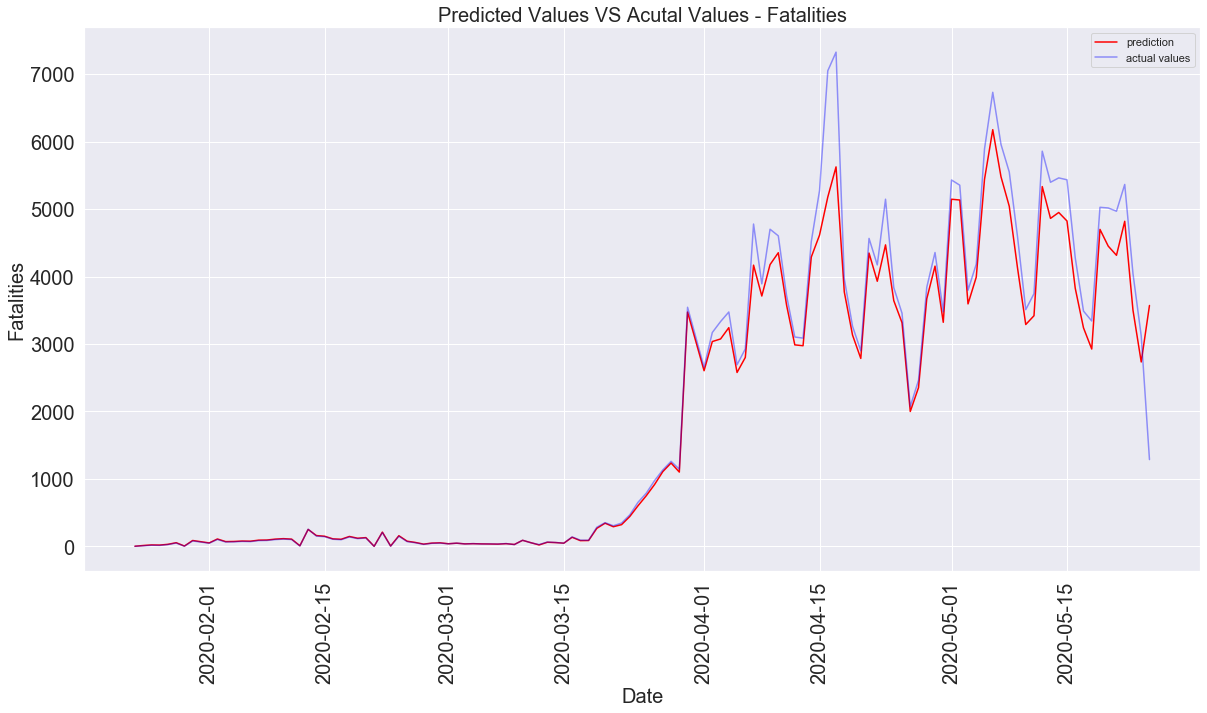

In [196]:
plt.figure(figsize=(20,10))
pa.groupby('Date')['Prediction'].sum().plot(kind='line',label='prediction',color='red',alpha=1)
pa.groupby("Date")['Actual Values'].sum().plot(kind='line',label='actual values',color='blue',alpha=0.4)
plt.xticks(rotation=90,size=20)
plt.yticks(size=20)

plt.ylabel('Fatalities',fontsize=20)
plt.xlabel('Date',fontsize=20)
plt.title('Predicted Values VS Acutal Values - Fatalities',fontsize=20)
plt.legend()


In [197]:
from sklearn.metrics import mean_squared_error
def RMSE(actual,prediction):
    rmse = np.sqrt(mean_squared_error(actual,prediction))
    print(rmse)

In [198]:
RMSE(y_test[:-1],[i[0] for i in y_test_pre][1:])

13.748094460275327
